# Set up environment

| torch.__version__ | torchvision.__version__ | fastai.__version__ |                                                           |
| ----------------- | ----------------------- | ------------------ | --------------------------------------------------------- |
| 1.11.0            | 0.12.0                  | 2.5.6              | ✓                                                         |
| 1.9.1, 1.10.0     | 0.10.1                  | 2.5.3              | ✓                                                         |
| 1.6.0             | 0.7.0                   | 2.0.18             | ✗ (use [this](https://github.com/baidut/PatchVQ) instead) |



[Optional] Create a virtual environment

1. install [miniconda](https://docs.conda.io/en/latest/miniconda.html)
1. `conda create --name venv python=3.9`
1. `conda activate venv`

Install packages:

1. [Pytorch](https://pytorch.org/get-started/locally/) 
2. `pip install jupyter timm seaborn wandb logru fastai`


In [ ]:
from fastiqa.basics import *

3.9.12 (main, Apr  5 2022, 06:56:58) 
[GCC 7.5.0]
fastai.__version__(>= 2.5.3): 2.5.6
fastcore.__version__: 1.4.2
torch.__version__(>= 1.9.1): 1.11.0 w/ cuda 
torchvision.__version__(>= 0.10.1): 0.12.0


# Test PatchVQ on your dataset

```
database_folder
├── labels.csv
├── dbinfo.json
├── jpg
│   ├── video1_image_folder
│   ├── video2_image_folder
│   └── ...
|
```

## Prepare dataset

1. Extract video frames
2. Under your dataset folder, put a json file (`dbinfo.json`) containing its key information:

```json
{
    "__name__": "LIVE_VQC",     # the name of the database
    "csv_labels": "labels.csv", # path to the label CSV file
    "fn_col": "name",           # filename column in the CSV table 
    "label_col": "mos",         # label column in the CSV table
    "folder": "jpg"             # the folder containing extracted video frames
}
```

## Extract features

[Optional] You can adjust the `bs`(batch size) when extracting features.

In [ ]:
# modify the path
JSON_FILE = '/home/zq/FB8T/db/LSVQ/dbinfo.json'

from fastiqa.patchvq.all import *
from fastiqa.paq2piq.all import *

# only show warnings and errors
logger.remove() 
logger.add(sys.stderr, level="SUCCESS")

dbinfo = load_dbinfo(JSON_FILE) 

print('Extract 2d features')
PatchVQ.roipool(LegacyRoIPoolModel(), dbinfo, featname='paq2piq', bs=32, clip_size=1)
PatchVQ.soipool('paq2piq', dbinfo)

print('Extract 3d features')
PatchVQ.roipool(RoIPoolModel(backbone=r3d18_K_200ep), dbinfo, featname='r3d18', bs=1, clip_num=40, clip_size=16)
PatchVQ.soipool('r3d18', dbinfo)

The extracted features will be saved under `features` folder

```
database_folder
├── labels.csv
├── dbinfo.json
├── jpg
│   ├── video1_image_folder
│   ├── video2_image_folder
│   └── ...
|
├── features  
│   ├── r3d18
│   └── r3d18_pooled
│   ├── paq2piq
│   └── paq2piq_pooled

```

## Extract scores

The results will be **cached** to current folder `valid@database_name.csv`.
Make sure to delete the cached file or set `cache=False` if you wish to re-generate the results. 

2022-04-14 10:08:22.477 | WARNING  | fastiqa.learn:get_np_preds:140 - load cache valid@LIVE_VQC_all.csv


,file,target,predicted
0,A001,80.2320,75.317010
1,A002,57.3005,61.868060
2,A003,78.1558,69.768196
3,A004,59.3179,71.576805
4,A005,47.1778,61.339127
...,...,...,...
580,P007,38.2139,51.683050
581,P008,38.4545,50.378487
582,P009,55.9663,60.937004
583,Q001,61.1466,56.057674


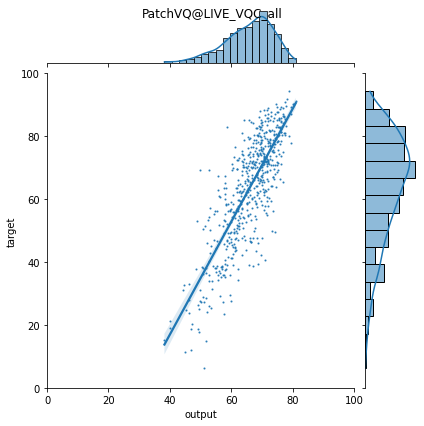

In [ ]:
from fastiqa.patchvq.all import *
from fastiqa.learn import TestLearner, IqaLearner

LIVE_VQC = load_dbinfo('/home/zq/FB8T/db/LIVE_VQC/dbinfo.json')
test_set = All(LIVE_VQC) # otherwise only the validation portion will be evaluated

model = PatchVQ()
model.eval()

learn = TestLearner(model=model)
output, target = learn.get_np_preds(test_set, cache=True, jointplot=True) 
filenames = pd.read_csv('/home/zq/FB8T/db/LIVE_VQC/labels.csv')['name'].tolist()
pd.DataFrame({'file': filenames, 'target': target, 'predicted': output})

# Test on existing databases:


3.9.12 (main, Apr  5 2022, 06:56:58) 
[GCC 7.5.0]
fastai.__version__(>= 2.5.3): 2.5.6
fastcore.__version__: 1.4.2
torch.__version__(>= 1.9.1): 1.11.0 w/ cuda 
torchvision.__version__(>= 0.10.1): 0.12.0


,spearmanr,pearsonr
KoNViD_all,0.793572,0.796615
LIVE_VQC_all,0.771129,0.806740


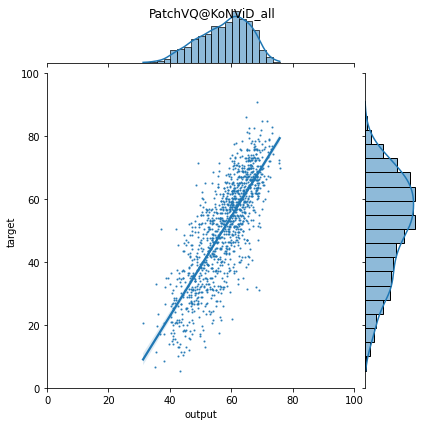

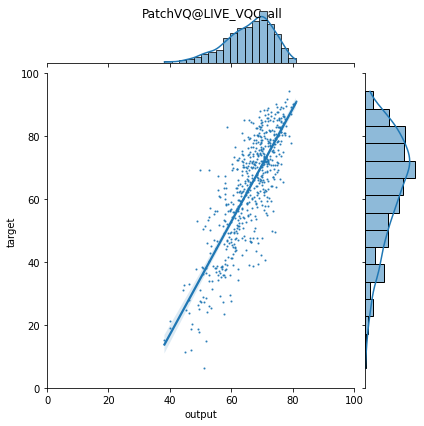

In [ ]:
from fastiqa.patchvq.main import *
from fastiqa.learn import TestLearner, IqaLearner
logger.remove() 

LIVE_VQC = load_dbinfo('/home/zq/FB8T/db/LIVE_VQC/dbinfo.json')
KoNViD = load_dbinfo('/home/zq/FB8T/db/KoNViD/dbinfo.json')

# load pretrained model
model = PatchVQ()
model_state = load_state_dict_from_url('https://github.com/baidut/PatchVQ/releases/download/v0.1/PatchVQ.pth')
model.load_state_dict(model_state)
model.eval()

learn = TestLearner(model=model)
learn.valid(db=[All(KoNViD), All(LIVE_VQC)])